<a href="https://colab.research.google.com/github/elaineMarinho/Machine_Learning_Practitioner/blob/main/Treinamento_de_Redes_Neurais_com_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import os
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt


from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

import os
import shutil
import zipfile
import requests
from PIL import Image
from PIL import UnidentifiedImageError



# **DOWNLOAD, LIMPEZA E DIMENSIONAMENTO DO DATASET**

In [ ]:
# Função para download do dataset
def download_dataset(url, output_path):
    response = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(response.content)

In [ ]:
# Função para extração de arquivo ZIP
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
# Função para limpeza e limitação de quantidade de imagens
def clean_and_limit_images(data_dir, categories, limit):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        valid_images = []

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verifica se a imagem está quebrada
                valid_images.append(img_name)
            except (IOError, SyntaxError):
                os.remove(img_path)  # Remove a imagem quebrada

        # Limita a quantidade de imagens
        for img_name in valid_images[limit:]:
            os.remove(os.path.join(category_path, img_name))


In [ ]:
# Indicação do dataset e dos arquivos
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
zip_path = "kagglecatsanddogs_5340.zip"
data_dir = "/content/cats_and_dogs_data/PetImages"
categories = ["Cat", "Dog"]
limit = 150

In [ ]:
# Download do dataset
print("Baixando Cats and Dogs Dataset")
download_dataset(dataset_url, zip_path)

Baixando Cats and Dogs Dataset


In [ ]:
# Extração dos arquivos
print("Extraindo arquivos...")
extract_zip(zip_path, "/content/cats_and_dogs_data")

Extraindo arquivos...


In [ ]:
# Limpando imagens e limitando a quantidade de imagens
print("Limpando imagens quebradas e limitando a quantidade de imagens")
clean_and_limit_images(data_dir, categories, limit)

Limpando imagens quebradas e limitando a quantidade de imagens


In [ ]:
# Verificando o conteúdo extraído
print("Conteúdo extraído:")
for category in categories:
    print(f"{category}: {len(os.listdir(os.path.join(data_dir, category)))} imagens")

Conteúdo extraído:
Cat: 150 imagens
Dog: 150 imagens


# **ALOCANDO AS IMAGENS NO DIRETÓRIO ROOT**

In [ ]:
root = '/content/cats_and_dogs_data/PetImages'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/cats_and_dogs_data/PetImages/Dog', '/content/cats_and_dogs_data/PetImages/Cat']


# **PRÉ-PROCESSAMENTO DOS DADOS EM UMA IMAGEM E VETOR DE ENTRADA**

In [ ]:
# Função para carregar a imagem e retornar a imagem e o vetor de entrada
def get_image(path):
    try:
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    except UnidentifiedImageError:
        # Print the path of the problematic image
        print(f"Skipping invalid image: {path}")
        # Return None to signal that the image loading failed
        return None, None

# **CARREGANDO TODAS AS IMAGENS NO DIRETÓRIO ROOT**

In [ ]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# Contando e exibindo o número de classes
num_classes = len(categories)
print(len(categories))

2


# **FORMATANDO EM DADOS ALEATÓRIOS**

In [ ]:
random.shuffle(data)

# **CRIANDO TREIANAMENTO / VALIDAÇÃO / DIVIVISÃO DE TESTES (70%, 15%, 15%)**

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

# **SEPARANDO DADOS**

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]


# **PRÉ-PROCESSANDO EM DADOS FLOAT32 E NORMALIZADOS ENTRE 1 E 0**

In [ ]:
# normaliza os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converter rótulos em vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(45, 2)


# **RESUMO DO QUE FOI FEITO**

In [ ]:
# Resumo
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 300 images from 2 categories
train / validation / test split: 210, 45, 45
training data shape:  (210, 224, 224, 3)
training labels shape:  (210, 2)


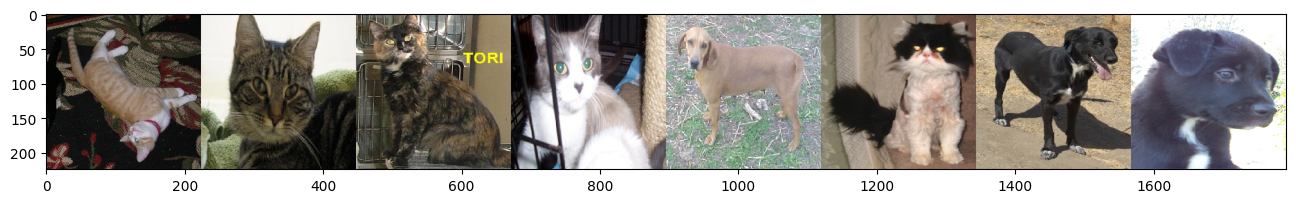

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# **TREINAMENTO DE UMA REDE NEURAL DO ZERO**

In [ ]:
# construindo a rede
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compilar o modelo para usar a função de perda de entropia cruzada categórica e o otimizador adadelta
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.4595 - loss: 0.7053 - val_accuracy: 0.4667 - val_loss: 0.6969
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.4495 - loss: 0.7238 - val_accuracy: 0.6000 - val_loss: 0.6857
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5817 - loss: 0.6843 - val_accuracy: 0.4667 - val_loss: 0.6895
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5476 - loss: 0.6903 - val_accuracy: 0.4667 - val_loss: 0.6893
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.5514 - loss: 0.6779 - val_accuracy: 0.4667 - val_loss: 0.6884
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.5676 - loss: 0.6762 - val_accuracy: 0.6444 - val_loss: 0.6788
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.6242 - loss: 0.6584 - val_accuracy: 0.6000 - val_loss: 0.6684
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.6542 - loss: 0.6518 - val_accuracy: 0.6222 - val_loss: 0.6603
Epoch 9/

# **REPRESENTAÇÃO GRÁFICA PERDA DE VALIDAÇÃ E PRECISÃO AO LONGO DO TEMPO**

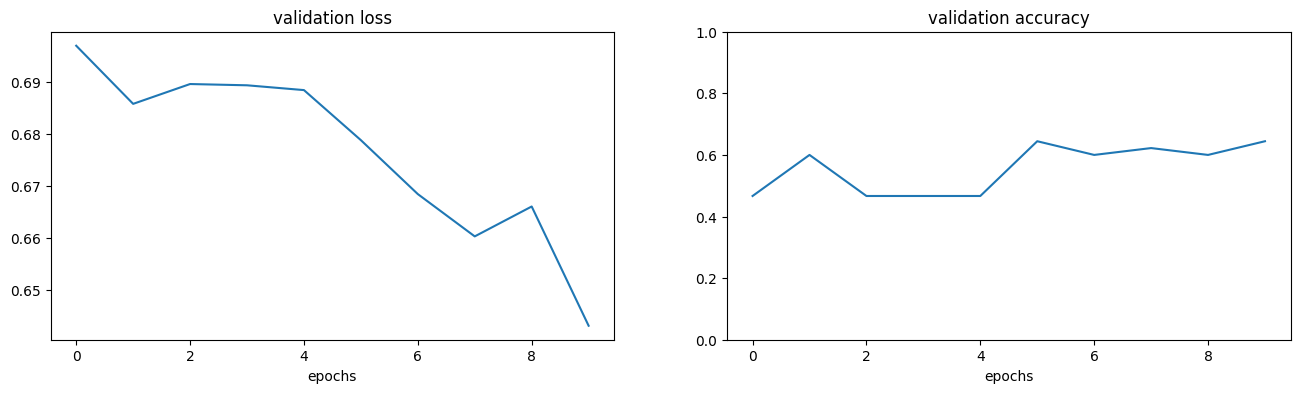

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss) # perda no conjunto de teste
print('Test accuracy:', accuracy) # acurácia no conjunto de teste

Test loss: 0.6466277837753296
Test accuracy: 0.5333333611488342


# **TRANFER LEARNING COM MODELO EXISTENTE**

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# faz uma referência à camada de entrada do VGG
inp = vgg.input

# faz uma nova camada softmax com neurônios num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# conecta a nova camada à penúltima camada em VGG e faz uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede entre entrada e saída
model_new = Model(inp, out)

In [ ]:
# torna todas as camadas intratáveis ​​congelando pesos (exceto a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada seja treinável/não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 168s 82s/step - accuracy: 0.4783 - loss: 0.9931 - val_accuracy: 0.5333 - val_loss: 0.7469
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 160s 81s/step - accuracy: 0.4558 - loss: 0.8704 - val_accuracy: 0.4667 - val_loss: 1.1735
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 172s 93s/step - accuracy: 0.5251 - loss: 1.0132 - val_accuracy: 0.4667 - val_loss: 0.7098
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 158s 79s/step - accuracy: 0.5433 - loss: 0.6495 - val_accuracy: 0.5556 - val_loss: 0.7033
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 204s 79s/step - accuracy: 0.4853 - loss: 0.8042 - val_accuracy: 0.6222 - val_loss: 0.6181
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 159s 80s/step - accuracy: 0.5736 - loss: 0.6535 - val_accuracy: 0.5778 - val_loss: 0.6200
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 202s 79s/step - accuracy: 0.5815 - loss: 0.5977 - val_accuracy: 0.4667 - val_loss: 0.7324
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 164s 84s/step - accuracy: 0.5349 - loss: 0.6411 - val_accuracy: 0.7556 - val_loss:

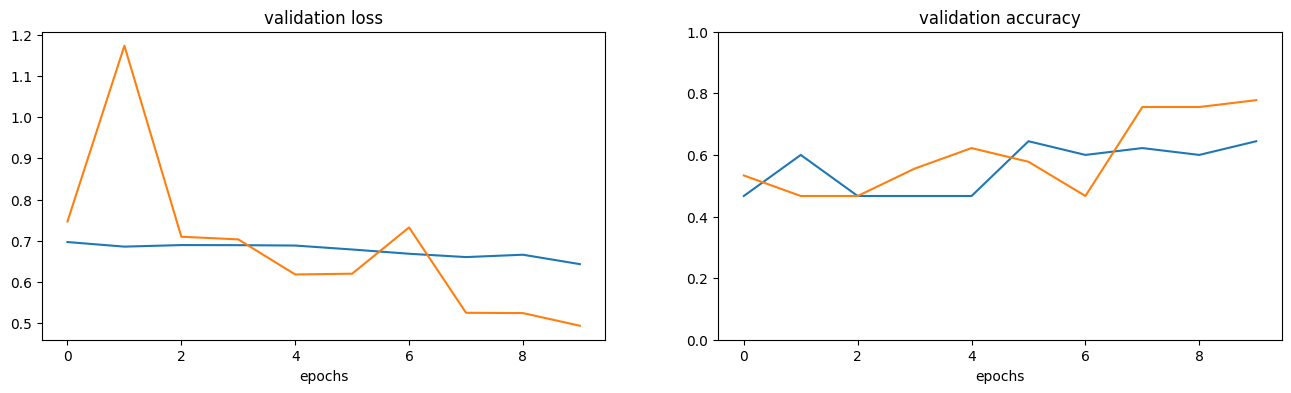

In [ ]:
# Cria uma figura com dois subgráficos (1 linha, 2 colunas)
fig = plt.figure(figsize=(16,4))

# Primeiro subgráfico - perda de validação (val_loss)
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

# Segundo subgráfico - acurácia de validação (val_accuracy)
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
# Avaliando a performance do modelo nos dados de teste
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5299991965293884
Test accuracy: 0.7111111283302307


# **PROBABILIDADE DE CLASSES**

In [ ]:
img, x = get_image('/content/cats_and_dogs_data/PetImages/Cat/10016.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
[[0.0126996  0.98730046]]
